In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays

In [2]:
#df_cons = pd.read_excel('datasets/Actual_consumption_202001010000_202011242359.xlsx', skiprows=6,na_values='-')
#df_price = pd.read_excel('datasets/Day-ahead_prices_202001010000_202011242359.xlsx', skiprows=6, na_values='-')
#df_gen = pd.read_excel('datasets/Actual_generation_202001010000_202011242359.xlsx', skiprows=6, na_values='-')

df_cons = pd.read_excel('datasets/Actual_consumption_201901010000_202011302359.xlsx', skiprows=6,na_values='-')
df_price = pd.read_excel('datasets/Day-ahead_prices_201901010000_202011302359.xlsx', skiprows=6, na_values='-')
df_gen = pd.read_excel('datasets/Actual_generation_201901010000_202011302359.xlsx', skiprows=6, na_values='-')

#Concatenate Date + Time and create TimeSeries
df_cons['Date'] = pd.to_datetime(df_cons['Date'] + ' ' + df_cons['Time of day'])
#Create Timeseries index for 
df_cons['Date'] = df_cons['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
#Drop Unused column
df_cons.drop('Time of day', axis=1, inplace=True)
#Create Timeseries index for
df_cons.set_index('Date', inplace=True)
#Convert to GWh for better Visualization
df_cons['Total[MWh]']/=1000
df_cons.rename(columns={'Total[MWh]': 'TotalConsumption[GWh]'}, inplace=True)

#Repeat the same steps for Prices Dataset
df_price['Date'] = pd.to_datetime(df_price['Date'] + ' ' + df_price['Time of day'])
df_price['Date'] = df_price['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
df_price.set_index('Date', inplace=True)
df_price.drop(df_price.columns[[0,2,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True)
#Remove Market Signals
df_price['Germany/Luxembourg[€/MWh]'] = df_price[df_price['Germany/Luxembourg[€/MWh]'] > 1]

#Repeat the same steps for Power Generation Dataset 
df_gen['Date'] = pd.to_datetime(df_gen['Date'] + ' ' + df_gen['Time of day'])
df_gen['Date'] = df_gen['Date'].dt.tz_localize('Europe/Berlin', ambiguous='infer')
df_gen.drop('Time of day', axis=1, inplace=True)
df_gen.set_index('Date', inplace=True)
6
#Create the Total Power Generation Column also known as Sypply
df_gen['TotalGeneration[MWh]'] = (df_gen['Biomass[MWh]'] + 
        df_gen['Hydropower[MWh]']+
        df_gen['Wind offshore[MWh]'] +
        df_gen['Wind onshore[MWh]']+
        df_gen['Photovoltaics[MWh]']+
        df_gen['Other renewable[MWh]']+ 
        df_gen['Nuclear[MWh]']+ 
        df_gen['Fossil brown coal[MWh]']+
        df_gen['Fossil hard coal[MWh]']+ 
        df_gen['Fossil gas[MWh]']+ 
        df_gen['Hydro pumped storage[MWh]']+
        df_gen['Other conventional[MWh]'])

#Convert all columns to GWh
df_gen['TotalGeneration[MWh]']/=1000  
df_gen['Biomass[MWh]']/=1000
df_gen['Hydropower[MWh]']/=1000
df_gen['Wind offshore[MWh]']/=1000
df_gen['Wind onshore[MWh]']/=1000
df_gen['Photovoltaics[MWh]']/=1000
df_gen['Other renewable[MWh]']/=1000
df_gen['Nuclear[MWh]']/=1000
df_gen['Fossil brown coal[MWh]']/=1000
df_gen['Fossil hard coal[MWh]']/=1000
df_gen['Fossil gas[MWh]']/=1000
df_gen['Hydro pumped storage[MWh]']/=1000
df_gen['Other conventional[MWh]']/=1000

df_gen.rename(columns={'TotalGeneration[MWh]': 'TotalGeneration[GWh]',
                       'Biomass[MWh]':'Biomass[GWh]',
                       'Hydropower[MWh]': 'Hydropower[GWh]',
                       'Wind offshore[MWh]': 'Wind offshore[GWh]',
                       'Wind onshore[MWh]':'Wind onshore[GWh]',
                       'Photovoltaics[MWh]':'Photovoltaics[GWh]',
                       'Other renewable[MWh]':'Other renewable[GWh]',
                       'Nuclear[MWh]':'Nuclear[GWh]',
                       'Fossil brown coal[MWh]':'Fossil brown coal[GWh]',
                       'Fossil hard coal[MWh]':'Fossil hard coal[GWh]',
                       'Fossil gas[MWh]':'Fossil gas[GWh]',
                       'Hydro pumped storage[MWh]':'Hydro pumped storage[GWh]',
                       'Other conventional[MWh]':'Other conventional[GWh]'                      
                      }, inplace=True)


#Downsample datasets to a daily frequency 
df_dcons = df_cons.resample('D').sum()
df_dgen = df_gen.resample('D').sum()
df_dprice = df_price.resample('D').median()

#Merge Datasets into a single one
df = pd.merge(df_dcons, df_dgen, left_index=True, right_index=True )
df = pd.merge(df, df_dprice, left_index=True, right_index=True )

#Calculate Non-base Demand According to the chosen paper
df['Non-base Demand[GWh]'] = df['TotalConsumption[GWh]'] - df['Hydropower[GWh]'] - df['Nuclear[GWh]']
#Calculate Supply-Demand Index
df['SupplyDemandIndex[SDI]'] = (df['TotalGeneration[GWh]'] - df['TotalConsumption[GWh]'])/ df['TotalConsumption[GWh]']*100

#Get weekday
df['DoW'] = df.index.dayofweek

#Get holidays in Germany
de_holidays = holidays.DEU()
df['Weekend/Holiday'] = df.apply(lambda x: x.name in de_holidays or x.DoW in [5,6], axis=1)

#remove rolls without prices
df = df[~df['Germany/Luxembourg[€/MWh]'].isnull()]
df['PriceDeviation'] = df['Germany/Luxembourg[€/MWh]'].rolling(90).std(win_type='gaussian')
#For displaying purpose
df['Non-base Demand[10GWh]'] = df['Non-base Demand[GWh]'] / 10

#Calculate Price Spike
df['PriceSpike'] =  df['Germany/Luxembourg[€/MWh]'] > df['Germany/Luxembourg[€/MWh]'].rolling(90).mean() + df['PriceDeviation'] * 2

<AxesSubplot:xlabel='Date'>

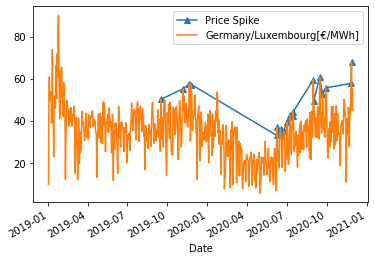

In [3]:
df[df['PriceSpike']]['Germany/Luxembourg[€/MWh]'].plot(marker='^',label='Price Spike', legend=True)
df['Germany/Luxembourg[€/MWh]'].plot(legend=True)

<AxesSubplot:xlabel='Date'>

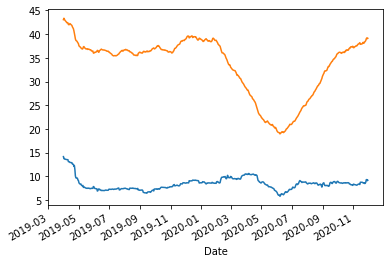

In [4]:
df['PriceDeviation'].plot()
df['Germany/Luxembourg[€/MWh]'].rolling(90).mean().plot()

<AxesSubplot:xlabel='Date'>

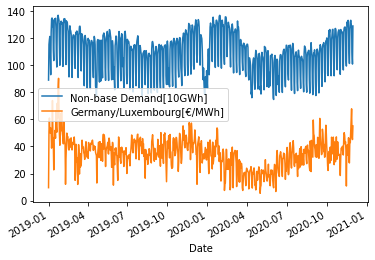

In [5]:
df[['Non-base Demand[10GWh]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)

<AxesSubplot:xlabel='Date'>

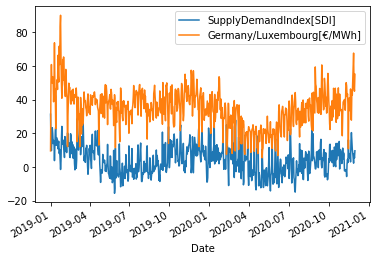

In [6]:
df[['SupplyDemandIndex[SDI]', 'Germany/Luxembourg[€/MWh]']].plot(legend=True)


In [7]:
#Skip Temperature and Capacity-Flow for simplicity

<AxesSubplot:xlabel='TotalConsumption[GWh]', ylabel='Germany/Luxembourg[€/MWh]'>

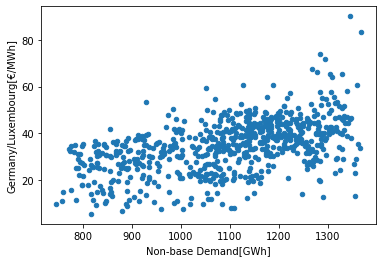

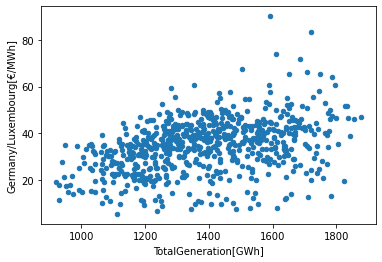

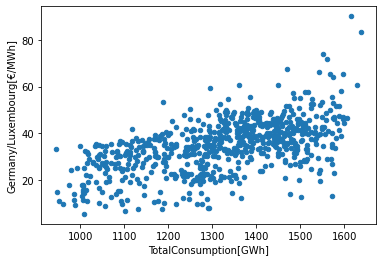

In [8]:
df.plot(kind='scatter', x='Non-base Demand[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalGeneration[GWh]' ,y='Germany/Luxembourg[€/MWh]' )
df.plot(kind='scatter', x='TotalConsumption[GWh]' ,y='Germany/Luxembourg[€/MWh]' )

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2019-01-01 00:00:00+01:00 to 2020-11-30 00:00:00+01:00
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TotalConsumption[GWh]      699 non-null    float64
 1   Residual load[MWh]         699 non-null    float64
 2   Biomass[GWh]               699 non-null    float64
 3   Hydropower[GWh]            699 non-null    float64
 4   Wind offshore[GWh]         699 non-null    float64
 5   Wind onshore[GWh]          699 non-null    float64
 6   Photovoltaics[GWh]         699 non-null    float64
 7   Other renewable[GWh]       699 non-null    float64
 8   Nuclear[GWh]               699 non-null    float64
 9   Fossil brown coal[GWh]     699 non-null    float64
 10  Fossil hard coal[GWh]      699 non-null    float64
 11  Fossil gas[GWh]            699 non-null    float64
 12  Hydro pumped storage[GWh]  699 non-null    float64
 13  O